# ADAM and How Adverserial Examples affects its Performance

### Overview of this Notebook: <br>
#### 1. Import of Python libraries and the dataset<br>
#### 2. Tuning of the Hyperparameters of the Mini-Batch Optimiser<br>
#### 3. Training a Naive Model<br>
#### 4. Evaluate the Attack against the Naive Model<br>
#### 5. Training a Robust Model <br>
#### 6. Evaluate the Attack against the Robust Model <br>
#### 7. Comparision of the two performances <br>

## Begin by importing the relevant libraries

In [1]:
# KUTAHYA PORSELEN
# Optimisation Algorithms in Non-Convex Classification Problems with Adversarial Training
import json
from adversary import attack, protect
from net import Net
import numpy as np
from torch.optim import Optimizer
import torch
from training import training, testing, accuracy, tune_optimizer
from adam import AdamOptimizer
from adam_run import adam_run, adam_tune, adam_build
import matplotlib.pyplot as plt
from data_utils import get_mnist, build_data_loaders
import json
from pathlib import Path
import random

In [19]:
# FIND BEST PARAMETERS FOR ADAM
def find_best_params_adam(adam_tuning):
    best_params = dict()
    best_params['loss_test'] = float('inf')
    best_params['acc_test'] = -float('inf')
    
    for item in adam_tuning:
        if best_params['acc_test'] < item['metric_test'] or best_params['loss_test'] > item['loss_test']:
            best_params['loss_train'] = item['loss_train']
            best_params['acc_train'] = item['metric_train']
            best_params['acc_test'] = item['metric_test']
            best_params['loss_test'] = item['loss_test']
            best_params['lr'] = item['lr']
            best_params['beta1'] = item['beta1']
            best_params['beta2'] = item['beta2']
            best_params['weight_decay'] = item['weight_decay']
            best_params['epsilon'] = item['epsilon']
            
    return best_params

#PRINT BEST PARAMETER SET OF ADAM AS WELL AS LOSS AND ACCURACY VALUES
def print_adam_stats(best_adam_params):
    print("Mean train loss value:",sum(best_adam_params['loss_train'])/len(best_adam_params['loss_train']))
    print("Lowest test loss value:",best_adam_params['loss_test'])
    print("Mean train accuracy value: {:.2f}%".format(100 * sum(best_adam_params['acc_train'])/len(best_adam_params['acc_train'])))
    print("Best test accuracy value: {:.2f}%" .format(100 * best_adam_params['acc_test']))
    print("Optimal Learning rate: ",best_adam_params['lr'])
    print("Optimal Beta1: ",best_adam_params['beta1'])
    print("Optimal Beta2: ",best_adam_params['beta2'])
    print("Optimal Weight Decay: ",best_adam_params['weight_decay'])
    print("Optimal Epsilon: ",best_adam_params['epsilon'])
    
def get_device():
    device = torch.device("cpu")
    if torch.cuda.is_available():
        use_cuda = input("CUDA is available, would you like to switch to cuda?(Y/N)")
        if use_cuda == 'Y' or use_cuda == 'y':
            print("Device is set to CUDA!")
            device = torch.device("cuda")
        else:
            print("Device is set to CPU!")
            device = torch.device("cpu")
    else:
        print("Device is set to CPU!")
    return device

In [18]:
#Best parameters
file = open('adam_tuning.json',)
adam_tuning = json.load(file)
best_adam_params = find_best_params_adam(adam_tuning)
print_adam_stats(best_adam_params)

Mean train loss value: 0.08408223207314121
Lowest test loss value: 0.03568430640809596
Mean train accuracy value: 97.58%
Best test accuracy value: 99.16%
Optimal Learning rate:  0.001
Optimal Beta1:  0.1
Optimal Beta2:  0.999
Optimal Weight Decay:  0.01
Optimal Epsilon:  1e-09


## Ready data and choose device(CPU/GPU)(GPU if available)

In [22]:
train_dataset, test_dataset = get_mnist(normalize=True)
criterion = torch.nn.CrossEntropyLoss()
epochs = 10
batch_size = 128

## Create dataloaders with requested batch size

In [24]:
device = get_device()
net_naive = Net().to(device)
train_loader, test_loader = build_data_loaders(train_dataset, test_dataset, batch_size)

Device is set to CPU!


In [26]:
adam_naive = AdamOptimizer(net_naive.parameters(), lr=best_adam_params['lr'], beta1=best_adam_params['beta1'],beta2=best_adam_params['beta2'],weight_decay=best_adam_params['weight_decay'],epsilon=best_adam_params['epsilon'])
loss_train, acc_train = training(net_naive, train_loader, adam_naive, criterion, accuracy, epochs=epochs, device=device)
loss_test, acc_test = testing(net_naive, test_loader, criterion, accuracy, device=device)

Launching training on cpu
batch 100	loss = 1.293	acc = 0.7266
batch 200	loss = 0.3408	acc = 0.8906
batch 300	loss = 0.2902	acc = 0.9062
batch 400	loss = 0.0969	acc = 0.9688
epoch 0	avg epoch loss = 0.6588	avg epoch acc = 0.8335
batch 100	loss = 0.135	acc = 0.9609
batch 200	loss = 0.1628	acc = 0.9766
batch 300	loss = 0.07345	acc = 0.9844
batch 400	loss = 0.01535	acc = 1.0
epoch 1	avg epoch loss = 0.09639	avg epoch acc = 0.9702
batch 100	loss = 0.07025	acc = 0.9688
batch 200	loss = 0.119	acc = 0.9688
batch 300	loss = 0.04029	acc = 0.9922
batch 400	loss = 0.005238	acc = 1.0
epoch 2	avg epoch loss = 0.0565	avg epoch acc = 0.9819
batch 100	loss = 0.01636	acc = 0.9922
batch 200	loss = 0.08295	acc = 0.9844
batch 300	loss = 0.04021	acc = 0.9844
batch 400	loss = 0.004928	acc = 1.0
epoch 3	avg epoch loss = 0.04078	avg epoch acc = 0.9873
batch 100	loss = 0.007227	acc = 1.0
batch 200	loss = 0.07279	acc = 0.9844
batch 300	loss = 0.02256	acc = 0.9922
batch 400	loss = 0.002037	acc = 1.0
epoch 4	avg e

## Attack naive model

In [28]:
noise = np.arange(0, 0.5, 0.05)

accuracy_naive= []
losses_naive= []

for ns in noise:
    loss_attack, acc_attack  = attack(net_naive, criterion, test_loader, epsilon=ns, device=device)
    accuracy_naive.append(acc_attack)
    losses_naive.append(loss_attack)

Epsilon: 0.00	Test Accuracy = 0.970
Epsilon: 0.05	Test Accuracy = 0.966
Epsilon: 0.10	Test Accuracy = 0.960
Epsilon: 0.15	Test Accuracy = 0.950
Epsilon: 0.20	Test Accuracy = 0.939
Epsilon: 0.25	Test Accuracy = 0.923
Epsilon: 0.30	Test Accuracy = 0.898
Epsilon: 0.35	Test Accuracy = 0.864
Epsilon: 0.40	Test Accuracy = 0.820
Epsilon: 0.45	Test Accuracy = 0.762


## Train robust model

In [31]:
robust_net = Net().to(device)
protect_epochs = epochs
protect_bz = 128
prot_train_loader, prot_test_loader = build_data_loaders(train_dataset, test_dataset, protect_bz)
adam_proc = AdamOptimizer(robust_net.parameters(), lr=best_adam_params['lr'], beta1=best_adam_params['beta1'],beta2=best_adam_params['beta2'],weight_decay=best_adam_params['weight_decay'],epsilon=best_adam_params['epsilon'])

## Call the protect function and make the model robust

In [33]:
robust_net = protect(robust_net, adam_proc, criterion, prot_train_loader, prot_test_loader, device=device, epochs=protect_epochs)

Epoch 0.00 | Test accuracy: 0.88637
Epoch 1.00 | Test accuracy: 0.93839
Epoch 2.00 | Test accuracy: 0.93275
Epoch 3.00 | Test accuracy: 0.92969
Epoch 4.00 | Test accuracy: 0.92613
Epoch 5.00 | Test accuracy: 0.92820
Epoch 6.00 | Test accuracy: 0.92445
Epoch 7.00 | Test accuracy: 0.93829
Epoch 8.00 | Test accuracy: 0.93493
Epoch 9.00 | Test accuracy: 0.93384
training took 910.4 s


## Attack  the Robust Model

In [36]:
noise = np.arange(0, 0.5, 0.05)
accuracy_robust = []
losses_robust = []

for ns in noise:
    loss_attack, acc_attack = attack(robust_net, criterion, prot_train_loader, ns, device=device)
    accuracy_robust.append(acc_attack)
    losses_robust.append(loss_attack)

Epsilon: 0.00	Test Accuracy = 0.991
Epsilon: 0.05	Test Accuracy = 0.990
Epsilon: 0.10	Test Accuracy = 0.988
Epsilon: 0.15	Test Accuracy = 0.986
Epsilon: 0.20	Test Accuracy = 0.984
Epsilon: 0.25	Test Accuracy = 0.981
Epsilon: 0.30	Test Accuracy = 0.976
Epsilon: 0.35	Test Accuracy = 0.969
Epsilon: 0.40	Test Accuracy = 0.957
Epsilon: 0.45	Test Accuracy = 0.940


## Comparative Analysis of the Two Models

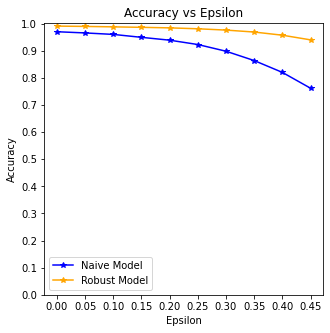

In [38]:
plt.figure(figsize=(5,5))
plt.plot(noise, accuracy_naive, "*-", c='blue', label='Naive Model')
plt.plot(noise, accuracy_robust, "*-", c='orange', label='Robust Model')

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 0.5, step=0.05))

plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend();